# Traffic Sign Recognition Model
## Environment Initialisation

In [1]:
def IntialiseEnv():
    nb_dir = os.path.split(os.getcwd())[0]
    if nb_dir not in sys.path:
        sys.path.append(nb_dir)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls
import os
os.chdir("My Drive/[ Masters ] - Deep Learning Proj/Model")
!pip install import_ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'My Drive'


In [3]:
# Libraries
import os
import sys
import tensorflow as tf
import numpy as np
import math
IntialiseEnv()
import import_ipynb
import pickle
from sklearn.model_selection import train_test_split

## Use GPU/ CPU Configuration 
Tensorflow version 2.0
Prompt to user if CPU/ GPU is in use with device name

In [4]:
# Use GPU/CPU Configurations

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
/device:GPU:0
Num GPUs Available:  1


## Reading DataSet
Pre-processing and Loading Train and Test DataSet respectively

In [5]:
def ReadTrainDataSet():
    print("Reading Train Pre-processed DataSet")
    processedTrainDataSet = 'Processed_DataSet/BelgiumTrainDataSet.pkl'
    isProcessedTrainDataSetExits= os.path.exists(processedTrainDataSet)
    train_image_array, train_image_labels = None, None
    
    if isProcessedTrainDataSetExits:
        print("Loading Processed Train DataSet from Processed_DataSet/BelgiumTrainDataSet.pkl")
        file = open(processedTrainDataSet, 'rb')
        train_image_array, train_image_labels = pickle.load(file)
        file.close()
        print("Done Loading Train DataSet.")
        
    else:
        print("Processed_DataSet/BelgiumTrainDataSet.pkl file does not exist")
        print("Loading Train DataSet ... This may take a while.")
        train_image_array, train_image_labels =  LoadTrainDataSetWithAugmentation()
        file = open(processedTrainDataSet, 'wb')
        pickle.dump((train_image_array, train_image_labels), file, protocol=4)
        file.close()
        print("Saving pre-processed train DataSets in Processed_DataSet/BelgiumTrainDataSet.pkl")
    return train_image_array, train_image_labels    

In [6]:
def ReadTestDataSet():
    processedTestDataSet = 'Processed_DataSet/BelgiumTestDataSet.pkl'
    isProcessedTestDataSetExits= os.path.exists(processedTestDataSet)
    test_image_array, test_image_labels = None, None
    
    if isProcessedTestDataSetExits:
        print("Loading Processed Test DataSet from Processed_DataSet/BelgiumTestDataSet.pkl")
        file = open(processedTestDataSet, 'rb')
        test_image_array, test_image_labels = pickle.load(file)
        file.close()
        print("Done Loading Test DataSet.")
    else:
        print("Processed_DataSet/BelgiumTestDataSet.pkl file does not exist")
        print("Loading Test DataSet ... This may take a while.")
        test_image_array, test_image_labels = LoadTestDataSet()
        file = open(processedTestDataSet, 'wb')
        pickle.dump((test_image_array, test_image_labels), file)
        file.close()
        print("Saving pre-processed test DataSets in Processed_DataSet/BelgiumTestDataSet.pkl")
    return test_image_array, test_image_labels

In [7]:
train_image_array, train_image_labels= ReadTrainDataSet()

Reading Train Pre-processed DataSet
Loading Processed Train DataSet from Processed_DataSet/BelgiumTrainDataSet.pkl
Done Loading Train DataSet.


In [ ]:
print(train_image_array.shape)

(4575, 60, 60, 1)


In [8]:
test_image_array, test_image_labels= ReadTestDataSet()

Loading Processed Test DataSet from Processed_DataSet/BelgiumTestDataSet.pkl
Done Loading Test DataSet.


In [ ]:
print(test_image_array.shape)

(2520, 60, 60, 1)


## Train-Split 
Split Train images dataset into two splits: training and validation respectively 80-20

In [9]:
image_train, image_valid,label_train, label_valid = train_test_split(train_image_array, train_image_labels,stratify=train_image_labels,test_size=0.1,random_state=43)

In [ ]:
print(image_train.shape)

(4117, 60, 60, 1)


In [10]:
del train_image_array
del train_image_labels

In [11]:
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Add,AveragePooling2D
from keras.models import Sequential
from keras.engine.topology import Layer
class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =Activation("linear", trainable=False)(x)
        x = Conv2D(self.channels_in,self.kernel, padding="same")(first_layer)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x= MaxPool2D(pooling)(x)
        x = Conv2D(self.channels_in,self.kernel,padding="same")(x)
        x = BatchNormalization()(x)
        residual= Add()([x, first_layer])
        x = Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


## Hyper-parameters Tuning

In [12]:
# Hyper-parameters tuning
kernel_2 = (3,3)
pooling = (2,2)
dropout = 0.2
num_classes = 62

## Model Architecture

In [13]:
import tensorflow as tf
import keras

from keras.layers import Layer
from keras.layers import Conv2D, SeparableConv2D,BatchNormalization,Dropout,MaxPool2D,Flatten,Dense
from keras.layers import concatenate

from keras import initializers
from keras import backend as K
from keras.layers import Input
from keras.models import Model

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer

if K.backend() == 'tensorflow':
    import tensorflow as tf

    def K_meshgrid(x, y):
        return tf.meshgrid(x, y)

    def K_linspace(start, stop, num):
        return tf.linspace(start, stop, num)

else:
    raise Exception("Only 'tensorflow' is supported as backend")


class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def get_config(self):
        return {
            'output_size': self.output_size,
        }

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(affine_transformation,
                                    shape=(batch_size, 2, 3))
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image

In [ ]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [ ]:
def dilated_block(X, num_channel, base):
    
    X_shortcut = X
    
    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_1')(X)
    X = Activation('relu', name=base + '/Branch1/relu_1')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_1')(X)

    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_2')(X)
    X= Activation('relu', name=base + '/Branch1/relu_2')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_2')(X)
    
    
    ##### Branch2 Start #####
    X_shortcut1 = BatchNormalization(axis=-1, name=base + '/Branch2/bn_1')(X_shortcut)
    X_shortcut1 = Activation('relu', name=base + '/Branch2/relu_1')(X_shortcut1)
    X_shortcut1 = Conv2D(num_channel, (3,3), strides=(1,1), dilation_rate=2, padding='same', name=base + '/Branch2/conv_1')(X_shortcut1)
    X = Add(name=base + '/Add1')([X, X_shortcut1])
    ##### Branch2 End #####
    
    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_3')(X)
    X= Activation('relu', name=base + '/Branch1/relu_3')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_3')(X)

    
    
    return X

In [14]:
weight_decay=1E-4
from keras.regularizers import l2

def model_():
    model = None
    tf.initializers.Orthogonal(gain=1.0, seed=None)
    model=Sequential()

    model.add(Conv2D(32,kernel_2, input_shape=(60,60,1), strides = 1, padding='valid',activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.1)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(128,kernel_2, strides = 1, padding='valid', activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.1)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(256,kernel_2, strides = 1, padding='valid', activation = tf.nn.relu,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_2, activation = tf.nn.relu,kernel_regularizer=l2(0.1)))
    model.add(MaxPool2D(pooling))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation = tf.nn.relu))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

In [ ]:
from tensorflow.keras.initializers import GlorotUniform

In [ ]:
def CNN_model():
    input_shape=(60, 60, 1)
    X_input= Input(input_shape)
    
    X = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1')(X_input)
    X = BatchNormalization(axis=-1, name='bn_1')(X)
    X = Activation('relu', name='relu_1')(X)    
    # X = dilated_block(X, 32, 'Block1')
 
    
    X = MaxPool2D((3,3), padding='same' ,name='pool_1')(X)
    
    X = dilated_block(X, 128, 'Block3')
    # X = dilated_block(X, 128, 'Block4')
    #X = dilated_conv_block(X, 64, 'Block5_pool')
    
    X = MaxPool2D((3,3), padding='same' ,name='pool_2')(X)
    
    
    X = dilated_block(X, 256, 'Block7')
    #X = dilated_conv_block(X, 128, 'Block7_pool')
    
    X = MaxPool2D((3,3), padding='same' ,name='pool_3')(X)
    
    # X = dilated_block(X, 256, 'Block8')
    #X = Conv2D(43, (3,3), strides=(1,1), padding='same', name='conv_9', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = MaxPool2D((8,8), strides=(1,1), name='avg_pool')(X)
    
    X = Flatten(name='Flatten')(X)
    X = Dense(512, name='Dense_1')(X)
    #X = Dropout(0.2)(X)
    X = Dense(num_classes, name='Dense_2')(X)
    X = Activation('softmax', name='classifier')(X)
    
    model = Model(inputs=X_input, outputs=X, name='Dilated_skipped_model')
    #model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

## Model Optimizer 

In [15]:
from tensorflow import keras
model = model_()



In [16]:



reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2,  verbose=1, min_delta=1e-4, min_lr=1e-20)
# optimizer = keras.optimizers.Adadelta()

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

In [18]:
x=aug.flow(image_train, np.array(label_train), batch_size=32)

## Model Training

In [25]:
history = model.fit(x, epochs=5, shuffle=True, validation_data=(image_valid, np.array(label_valid)),verbose=1,callbacks=[reduce_lr])             
                                      
                    
                   

Epoch 1/5
129/129 [==============================] - 8s 63ms/step - loss: 0.2590 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
129/129 [==============================] - 8s 62ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
129/129 [==============================] - 8s 62ms/step - loss: 0.2662 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.0479997697719911e-10.
Epoch 4/5
129/129 [==============================] - 8s 62ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
129/129 [==============================] - 8s 63ms/step - loss: 0.2611 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 1.0000


## Model Evaluation

In [26]:
model.evaluate(test_image_array, np.array(test_image_labels), batch_size=256s)

2520/2520 [==============================] - 1s 397us/step


[0.3092174431161275, 0.9896825551986694]

In [20]:
model.evaluate(test_image_array, np.array(test_image_labels), batch_size=256)

2520/2520 [==============================] - 2s 832us/step


[0.3091713826807718, 0.9896825551986694]

## Visualization

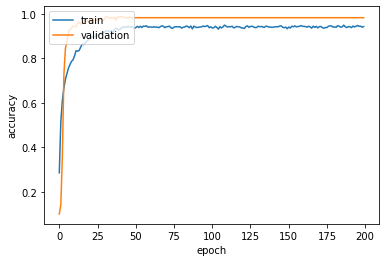

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

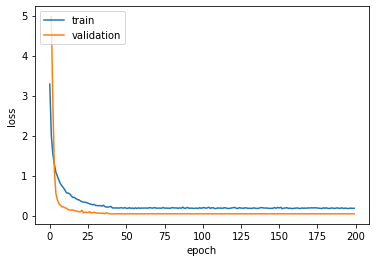

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Summary 
Number of parameters used in the model architecture

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 60, 32)        128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 60, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        3104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 29, 128)      

## Saving Trained .h5 Model

In [21]:
def saveCNNModel(model_name):
    model.save(model_name)

In [22]:
saveCNNModel('belgium_9896_94epoch.h5')

In [ ]:
model._set_inputs(image_train,np.array(label_train))

In [ ]:
del model

## Loading Saved Trained .h5 Model

In [ ]:
def load_model():
    Model = tf.keras.models.load_model('belgium_9888.h5')
    return Model

In [ ]:
del model
model= load_model()

In [ ]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

## Computation Avg. Processing Time

In [ ]:
import time
t1=time.time()
model.predict(test_image_array)
t2=time.time()
print("Average Processing time: ", ((t2-t1)/12630)*1000, " ms")